# Make a Survey Overview

**Goal**: Make a nice of all the data on a nice DEM 

**Approach**: 

1. Create an overview DEM with hillShade
2. Grab locations of single location type data
3. Grab centroids of all the raster tiles
4. Plot it all!

## Process:

### Step 1. Create an Overview Raster with HillShade

In [1]:
from snowxsql.db import get_db
from snowxsql.data import ImageData, LayerData, PointData, SiteData 
from snowxsql.conversions import raster_to_rasterio
from rasterio.plot import show
from sqlalchemy.sql import func
from geoalchemy2.types import Raster
import geoalchemy2.functions as gfunc
import matplotlib.pyplot as plt 
import geopandas as gpd
from shapely.geometry import Polygon
from geoalchemy2.shape import from_shape, to_shape

# Connect to the database we made.
db_name = 'snowex'
engine, session = get_db(db_name)

# DEM data name and surveyor
data_name = 'snow off digital elevation model'
surveyors = 'USGS'

# Resolution to make our DEM/Hillshade
res = 20

# Form a polygon to clip at the max extent (figured out in advance)
x1 = 735200.0
x2 = 760000.0
y1 = 4319989.0
y2 = 4329803.0

extent = Polygon([[x1, y1], [x1, y2], [x2, y2], [x2, y1]])       # Construct it using shapely

# Make the polygon usable to the db
extent_ewkt = from_shape(extent, srid=26912).ST_AsEWKT()

# Make polygon plottable for later
extent_df = gpd.GeoDataFrame({'geometry':[extent]})     

In [2]:
# Define a function to reduce the same code used for getting the dem and hillshade
def filter_and_return(session, base, data_name, surveyors, extent):
    '''
    Small function to apply redundent filters and raster making
    '''
    # Save our query as a Tiff and clip it along the extents polygon
    q = session.query(func.ST_AsTiff(func.ST_Clip(base, extent)))
    
    # Filter by data name and surveyor
    q = q.filter(ImageData.type == data_name)
    q = q.filter(ImageData.surveyors == surveyors)
    
    # Execute the query
    rasters = q.all()
    
    # Convert the dataset from the DB to rasterio
    dataset = raster_to_rasterio(session, rasters)[0]
    return dataset

In [3]:
# Create the base query to reduce code: Collect Rasters and rescale them to our resolution and use bilinear interpolation 
bq = func.ST_Rescale(ImageData.raster, res, -1 * res, 'blinear')

# Retrieve the dem, join all the tiles retrieved
base = gfunc.ST_Union(bq, type_=Raster) # Is NOT EXECUTED until query is executed.
dem = filter_and_return(session, base, data_name, surveyors, extent_ewkt) 

# Merge all the tiles retrieved, then make the hillshade.
base = func.ST_Hillshade(gfunc.ST_Union(bq, type_=Raster)) # Is NOT EXECUTED until query is executed.
hillshade = filter_and_return(session, base, data_name, surveyors, extent_ewkt)

### Step 2. Grab locations of single location type data

In [4]:
# Write a simple function to retrieve positional points of data
def grab_points(session, TableClass, data_name, distinct=False, instrument=None):
    '''
    Returns a dataframe of geometric points of requested data. Use distinct to avoid collecting 
    identical locations from layer data. Use instrument to isolate snow depths
    
    Returns: df: Geopandas dataframe with one column geometry for plotting
    '''
    q = session.query(TableClass.geom).filter(TableClass.type == data_name)
    
    if instrument != None:
        
        # Filter by what instruments are in a list provided
        if type(instrument) == list:
            q = q.filter(TableClass.instrument.in_(instrument))
        else:
            q = q.filter(TableClass.instrument == instrument)
    
    if distinct:
        q = q.distinct()
    
    points = q.all()
    
    # Make the points into a geopandas dataframe so we can easily plot it
    df = gpd.GeoDataFrame({'geometry':[to_shape(p[0]) for p in points]})
    print('Found {} points for {}...'.format(len(df.index), data_name))
    return df

In [5]:
session.rollback()
# Show all instruments used to gather snow depths
tools = session.query(PointData.instrument).filter(PointData.type == 'depth').distinct().all()
print(tools)

# Grab our pits by selecting hand hardness profiles
data = {}

# Use distinct locations from hand hardness profiles to get pit locations
pits = grab_points(session, LayerData, 'hand_hardness', distinct=True)

# Get distinct locations of smp profiles
smp = grab_points(session, LayerData, 'force', distinct=True)

# Grab all snow depths collected with magnaprobe, mesa, or a pit rule
depths = grab_points(session, PointData, 'depth', instrument=['magnaprobe', 'mesa', 'pit ruler'])

# Grab all the GPR point data
gpr = grab_points(session, PointData, 'two_way_travel')

[('mesa',), ('magnaprobe',), ('pulse EKKO Pro multi-polarization 1 GHz GPR',), ('pit ruler',)]
Found 167 points for hand_hardness...
Found 807 points for force...
Found 37921 points for depth...
Found 12651 points for two_way_travel...


### Step 3. Grab centroids of all the raster tiles

In [6]:
# Define a function to grab the center of each raster tile
def get_tile_centers(session, data_name, surveyors=None):
    '''
    Simple function to grab the center of each tile given a data type and optionally a surveyor name
    '''
    # Use database to grab the centroid of each tile outline (envelope) filtering on type. Also return the surveyor.
    q = session.query(func.ST_Centroid(func.ST_Envelope(ImageData.raster))).filter(ImageData.type == data_name)
    
    # If surveyors is provided, filter on that too
    if surveyors != None:
        q = q.filter(ImageData.surveyors == surveyors)
    
    centers = q.all()
    
    # Form the data into plottable geopandas dataframe with only a geometry column
    df = gpd.GeoDataFrame({'geometry':[to_shape(p[0]) for p in centers]})
    print('Found {} tiles for {}...'.format(len(df.index), data_name))
    return df

In [7]:
# Grab all the names of the raster data so we know what to reference
names = session.query(ImageData.type).distinct().all()
print(names)

# Use the get_tile_centers function to grab the dataframe containing the tile centroids and assign a color and marker to it for plotting
tiles = {}

# Grab all the ASO DEM centers, assign color as blue and use squares for symbols
tiles['ASO DEM'] = (get_tile_centers(session, 'snow off digital elevation model', surveyors='Airborne Snow Observatory'), 'royalblue', 's')

# Grab all the USGS DEM centers, assign color as light red and use pentagons for symbols
tiles['USGS DEM'] = (get_tile_centers(session, 'snow off digital elevation model', surveyors='USGS'), 'lightcoral','p')

# Grab all the insar data centers, assign color as some shade of orange and use diamonds for symbols
tiles['INSAR Amplitude'] = (get_tile_centers(session, 'insar amplitude'), 'gold', 'D')
tiles['INSAR Interferogram.'] = (get_tile_centers(session, 'insar interferogram real'), 'goldenrod', 'D') # Since imaginary and real are in the same location we only need one of them
tiles['INSAR Correlation.'] = (get_tile_centers(session, 'insar correlation'), 'bisque', 'D')

# Grab all the QSI rasters centers, assign color as some shade of purple and use dots for symbols
tiles['QSI DEM'] = (get_tile_centers(session, 'bare earth digital elevation models'), 'orchid','o')
tiles['QSI DSM'] = (get_tile_centers(session, 'digital surface models'), 'violet','o')


[('snow off digital elevation model',), ('insar amplitude',), ('insar correlation',), ('insar interferogram real',), ('bare earth digital elevation models',), ('insar interferogram imaginary',), ('digital surface models',)]
Found 194 tiles for snow off digital elevation model...
Found 1713 tiles for snow off digital elevation model...
Found 6096 tiles for insar amplitude...
Found 2016 tiles for insar interferogram real...
Found 2016 tiles for insar correlation...
Found 1246 tiles for bare earth digital elevation models...
Found 1246 tiles for digital surface models...


### Step 4. Plot it all!

Text(248.5, 0.5, 'Northing [m]')

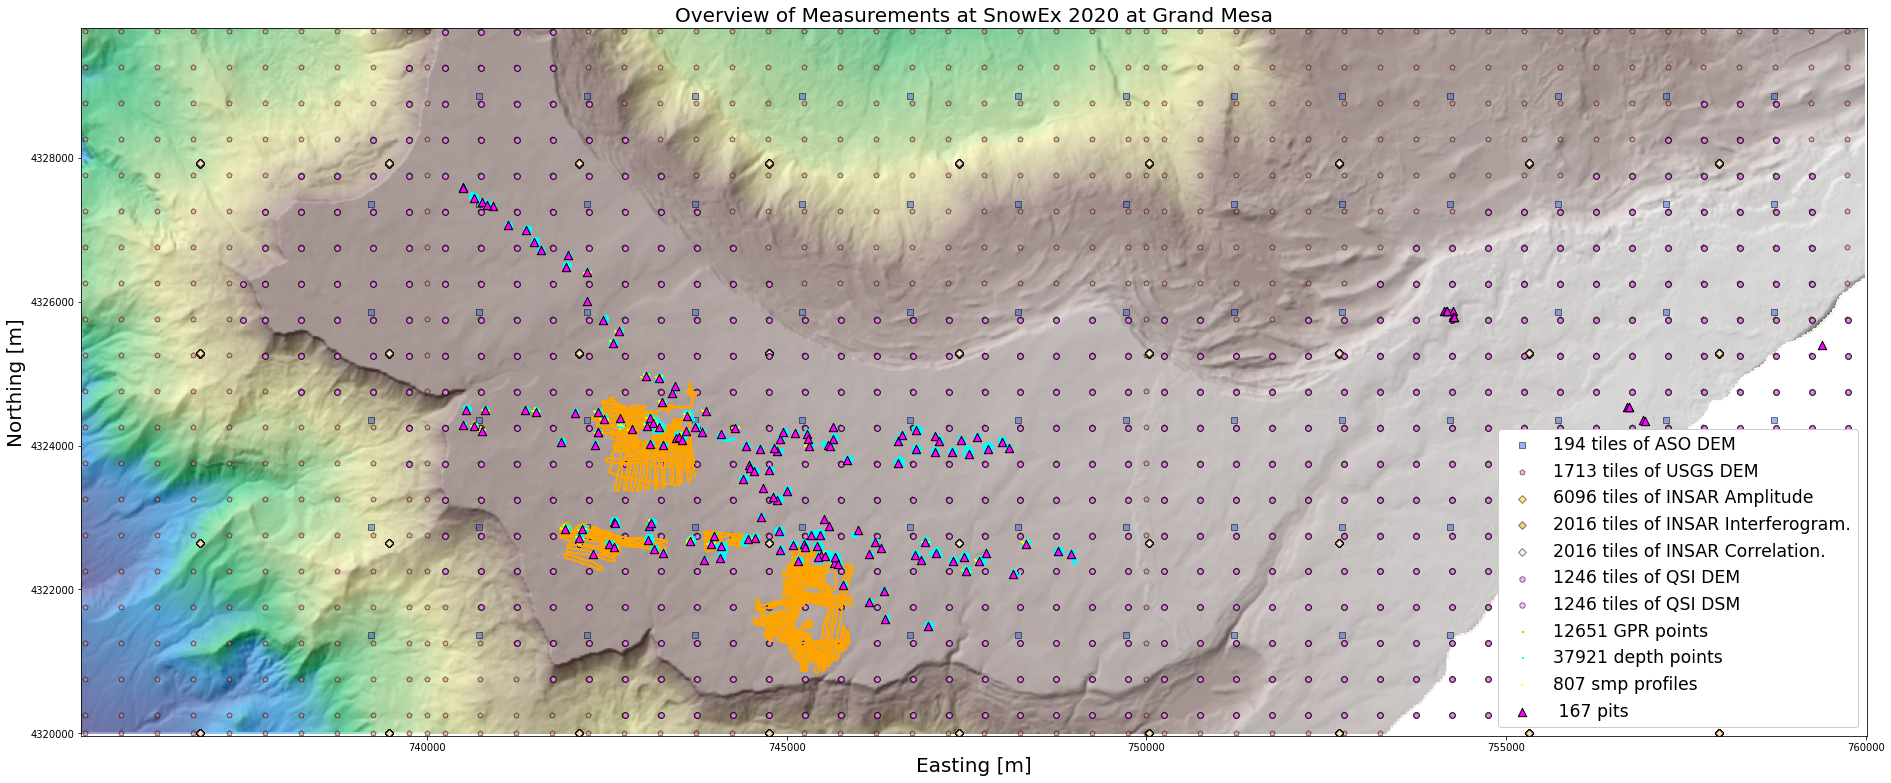

In [8]:
# Create a figure with one subplot. Give it size
fig, ax = plt.subplots(1,1, figsize=(32, 16))

# Plot the hillshade raster in gray
show(hillshade, ax=ax, cmap='gray', transform=hillshade.transform)

# Plot the DEM with partial transparency so the hillshade can be seen
show(dem, ax=ax, alpha=0.5, cmap='terrain', transform=dem.transform)

# Plot raster centers 
for n, d in tiles.items():
    df = d[0]
    color = d[1]
    marker = d[2]
    
    # Filter the data only to our map extent defined in the beginning
    ind = df.geometry.within(extent)
    
    # Plot with a name that shows the total tiles not just the tiles in the extent.
    df.loc[ind].plot(ax=ax, marker=marker, markersize=30, edgecolor='black', alpha=0.5,  color=color, label='{} tiles of {}'.format(len(df.index), n))

# Plot the GRP points as orange pixels
gpr.plot(ax=ax, marker=',' , color='orange', markersize=1, label='{} GPR points'.format(len(gpr.index)))

# Plot the snow depths using aqua colored pixels
depths.plot(ax=ax, marker=',' , color='aqua', markersize=1, label='{} depth points'.format(len(depths.index)))

# Plot the SMP positions with a yellow vertical pipe symbol
smp.plot(ax=ax, marker='|' , color='yellow', markersize=5, label='{} smp profiles'.format(len(smp.index)))

# Plot the pits as magenta triangles 
pits.plot(ax=ax, marker='^' , color='magenta', edgecolor='black', markersize=70, label=' {} pits'.format(len(pits.index)))

# Don't use scientific notation on the axis ticks
ax.ticklabel_format(style='plain', useOffset=False)

# Add some labeling
ax.legend(loc='lower right', fontsize='xx-large', framealpha=1.0)
ax.set_title('Overview of Measurements at SnowEx 2020 at Grand Mesa', size=20)
ax.set_xlabel('Easting [m]', size=20)
ax.set_ylabel('Northing [m]', size=20)

# Save the figure if you want
#plt.savefig('/SOME/LOCATION/')


In [9]:
session.close()